In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sys

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('iot_telemetry_data.csv')

In [6]:
df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        405184 non-null  float64
 1   device    405184 non-null  object 
 2   co        405184 non-null  float64
 3   humidity  405184 non-null  float64
 4   light     405184 non-null  bool   
 5   lpg       405184 non-null  float64
 6   motion    405184 non-null  bool   
 7   smoke     405184 non-null  float64
 8   temp      405184 non-null  float64
dtypes: bool(2), float64(6), object(1)
memory usage: 22.4+ MB


In [5]:
df.duplicated().sum()

13

In [6]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

ts          0
device      0
co          0
humidity    0
light       0
lpg         0
motion      0
smoke       0
temp        0
dtype: int64

In [9]:
# sort data
df = df.sort_values(by='ts', ascending=True)

In [10]:
# convert celsius to fahrenheit (°C to °F)
df['temp'] = (df['temp'] * 1.8) + 32

In [11]:
# preview data
df.head(5)

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000


In [12]:
# filter temp/humidity, by device, for outliers (>1% & <99%)
df = df.loc[df['temp'] >df.groupby('device').temp.transform(lambda x: x.quantile(.01))]
df = df.loc[df['temp'] < df.groupby('device').temp.transform(lambda x: x.quantile(.99))]

df = df.loc[df['humidity'] > df.groupby('device').humidity.transform(lambda x: x.quantile(.01))]
df = df.loc[df['humidity'] < df.groupby('device').humidity.transform(lambda x: x.quantile(.99))]

In [13]:
# group data by iot device
groups = df.groupby('device')

In [14]:
df['ts'] = pd.to_datetime(df['ts'], unit='s')

In [15]:
df.head(5)

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-12 00:01:34.385974528,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000
1,2020-07-12 00:01:34.735567616,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001
2,2020-07-12 00:01:38.073572864,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000
3,2020-07-12 00:01:39.589145856,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000
4,2020-07-12 00:01:41.761234944,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000


In [16]:
print('DataFrame Stats')
print('-------------')
print('Record count: {:,}'.format(df['temp'].count()))
print('DataFrame size (MB): {:,.2f}'.format(sys.getsizeof(df)/1024/1024))
print('-------------')
print('Time range (min): {:%Y-%m-%d %H:%M:%S %Z}'.format(df.ts.iloc[1]))
print('Time range (max): {:%Y-%m-%d %H:%M:%S %Z}'.format(df.ts.iloc[-1]))
print('Temperature (min): {:.2f}'.format(df['temp'].min()))
print('Temperature (max): {:.2f}'.format(df['temp'].max()))
print('Humidity (min): {:.2f}{}'.format(df['humidity'].min(), '%'))
print('Humidity (max): {:.2f}{}'.format(df['humidity'].max(), '%'))
print('-------------')
print('Record count:\n{}'.format(groups.size()))

DataFrame Stats
-------------
Record count: 385,452
DataFrame size (MB): 48.52
-------------
Time range (min): 2020-07-12 00:01:34 
Time range (max): 2020-07-20 00:03:37 
Temperature (min): 65.66
Temperature (max): 86.36
Humidity (min): 46.60%
Humidity (max): 90.70%
-------------
Record count:
device
00:0f:00:70:91:0a    106187
1c:bf:ce:15:ec:4d    101051
b8:27:eb:bf:9d:51    178214
dtype: int64


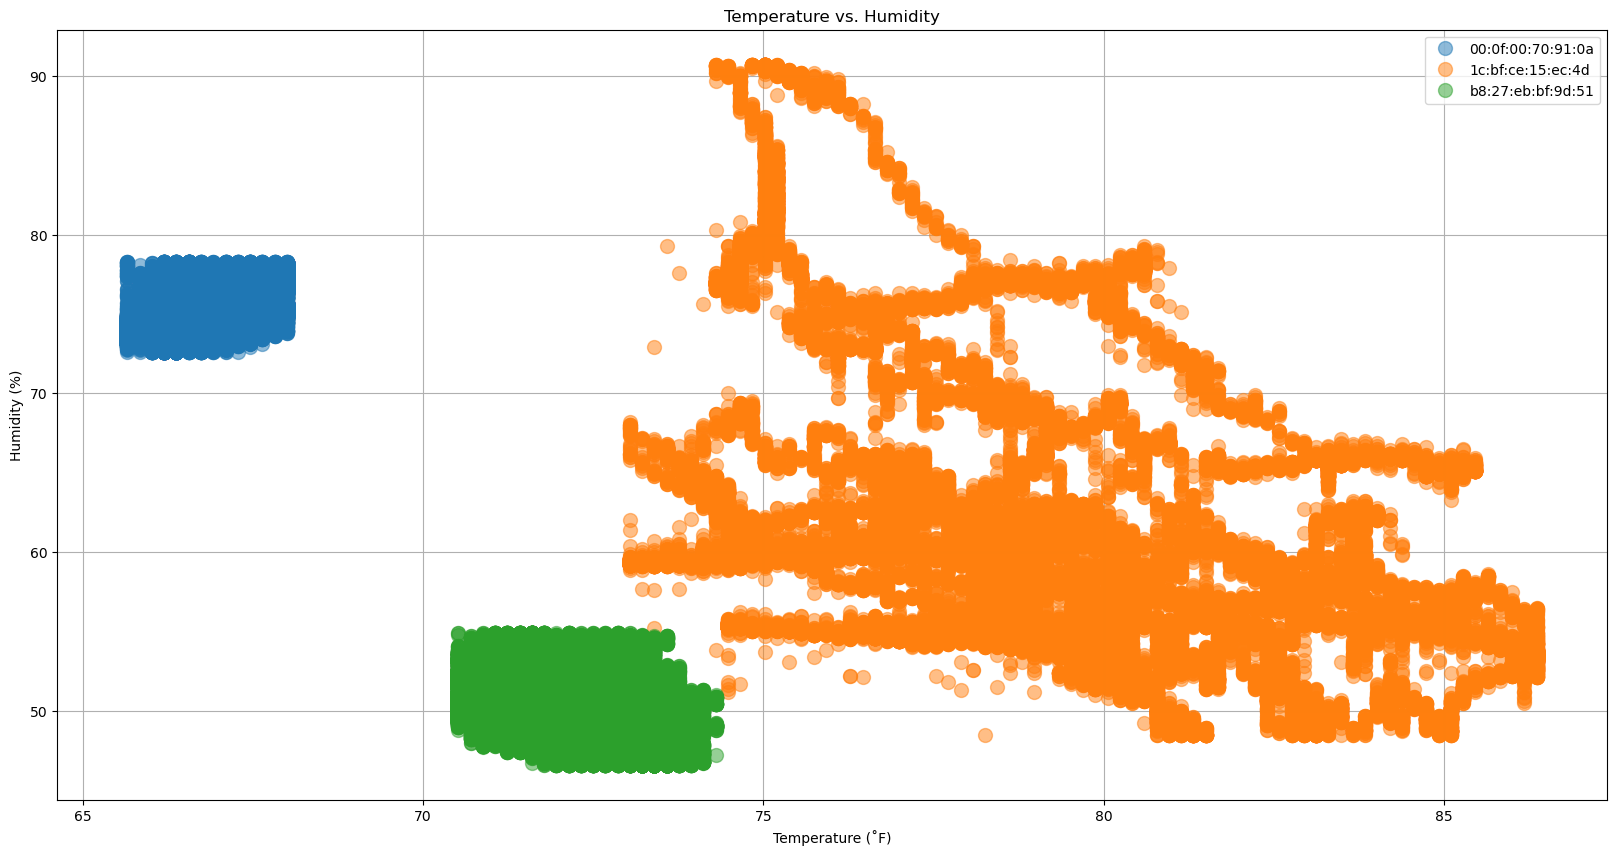

In [17]:
_, ax = plt.subplots(1, 1, figsize=(20, 10))
for device, group in groups:
    ax.plot(group.temp,
            group.humidity,
            marker='o',
            linestyle='',
            alpha=.5,
            ms=10,
            label=device)
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Temperature vs. Humidity')
plt.xlabel('Temperature (˚F)')
plt.ylabel('Humidity (%)')
plt.show()

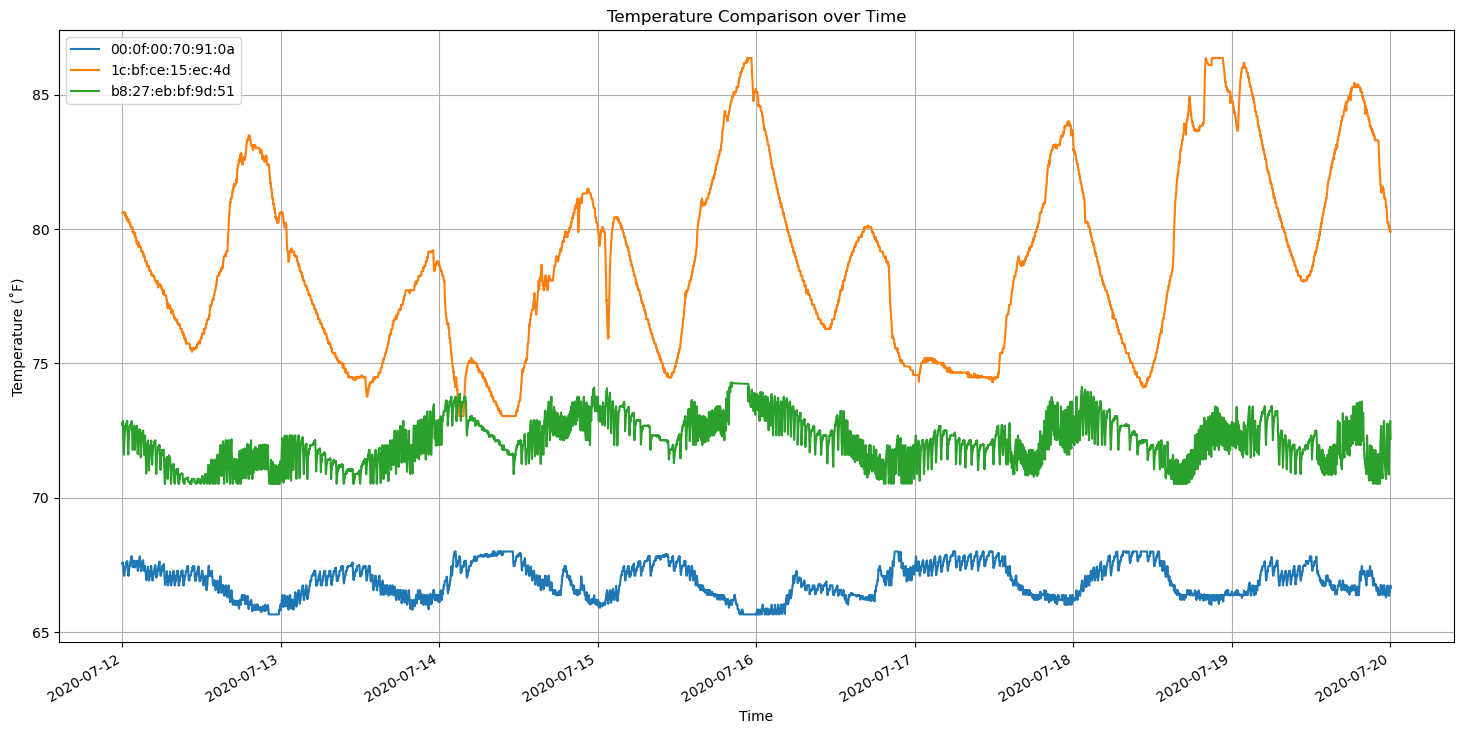

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for device, group in groups:
    group_mean = group.temp.rolling(window=20).mean()
    ax.plot(group.ts, group_mean, label=device)
    
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Temperature Comparison over Time')
plt.ylabel('Temperature (˚F)')
plt.xlabel('Time')
plt.show()

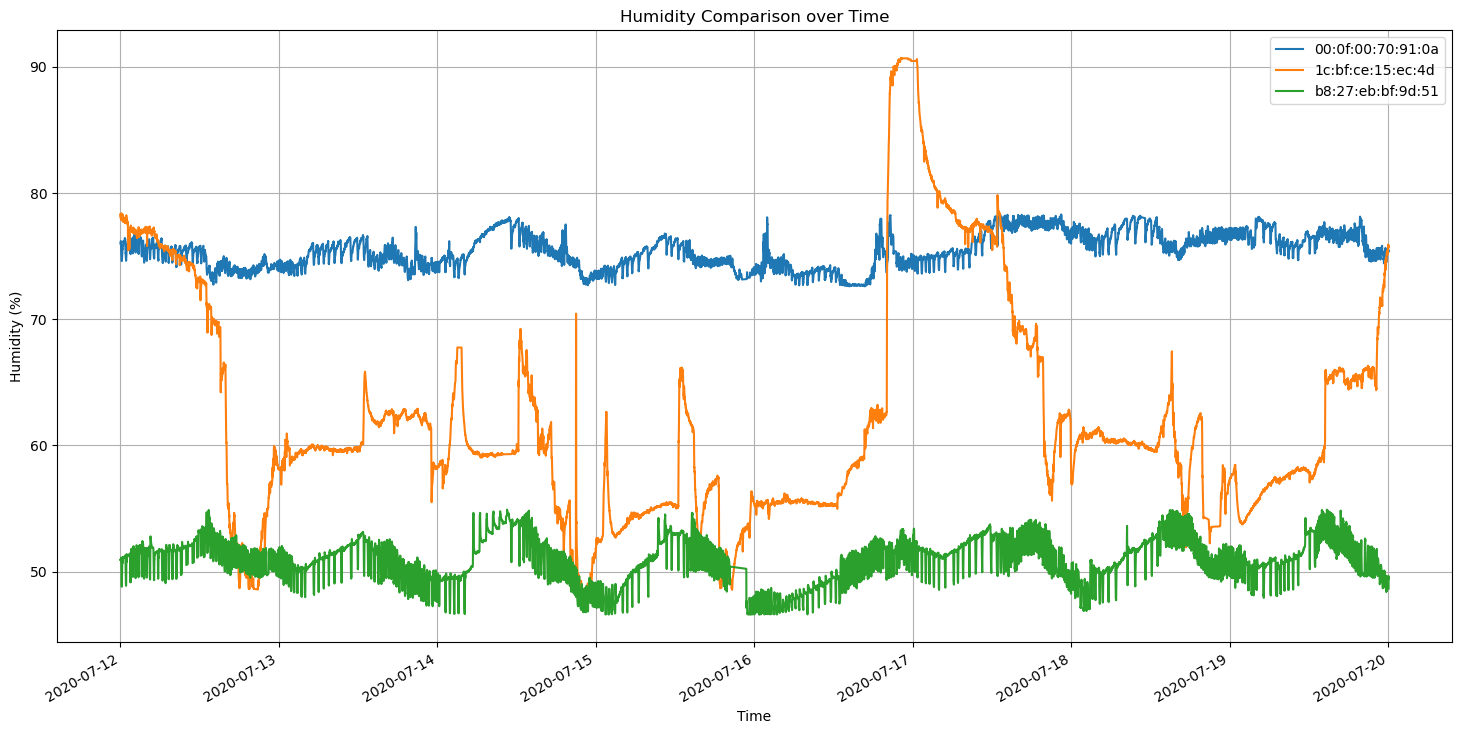

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for device, group in groups:
    group.mean = group.humidity.rolling(window=20).mean()
    ax.plot(group.ts,group.mean,
            label=device)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Humidity Comparison over Time')
plt.ylabel('Humidity (%)')
plt.xlabel('Time')
plt.show()

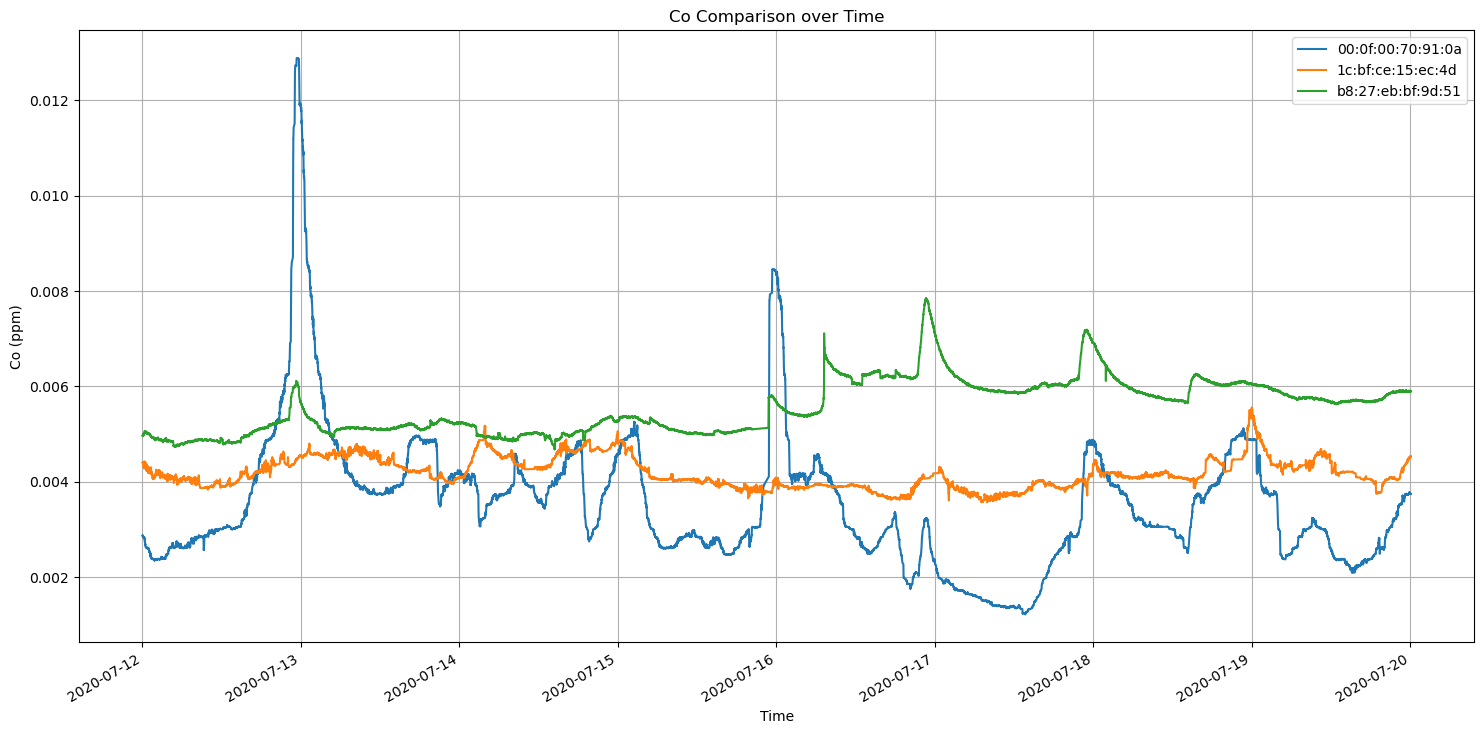

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for device, group in groups:
    group.mean = group.co.rolling(window=20).mean()
    ax.plot(group.ts,group.mean,
            label=device)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Co Comparison over Time')
plt.ylabel('Co (ppm)')
plt.xlabel('Time')
plt.show()

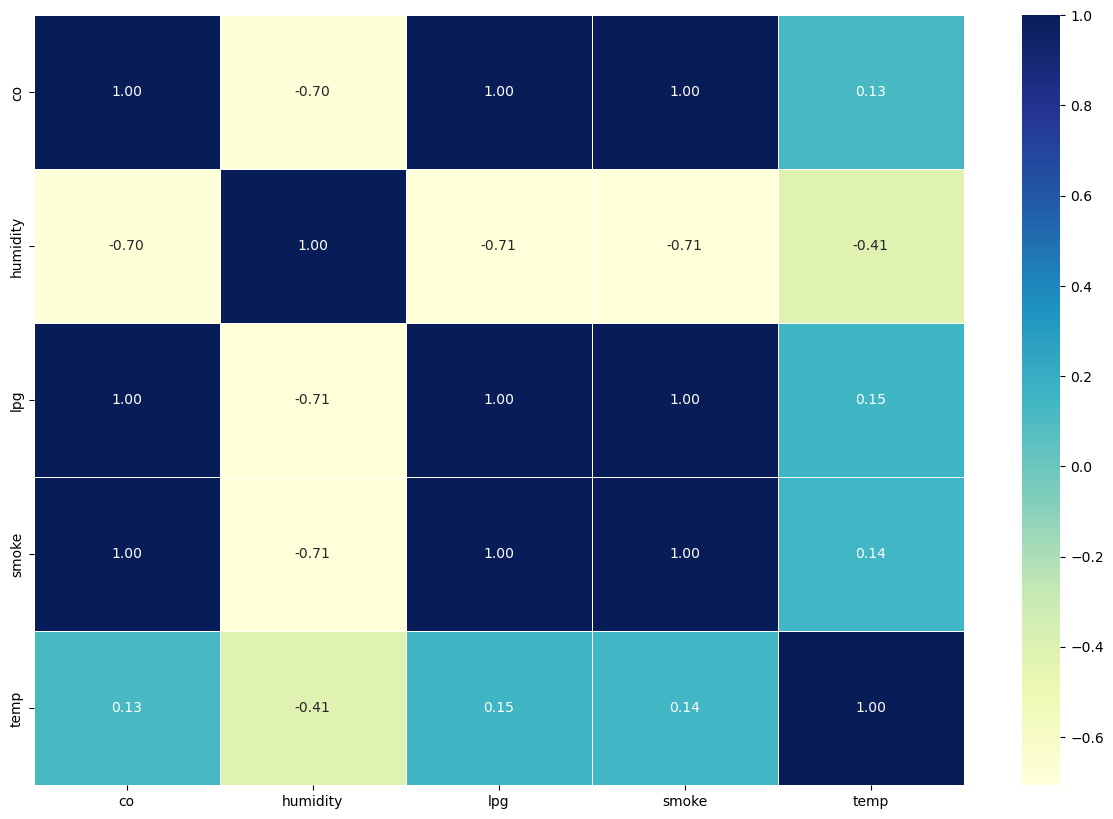

In [21]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numeric columns
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sn.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")
plt.show()

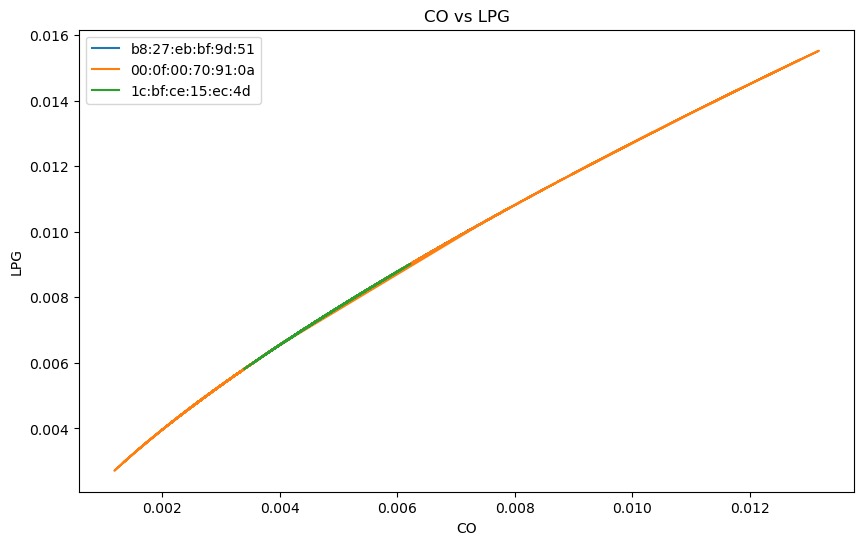

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique devices
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    ax.plot(device_data['co'], device_data['lpg'], label=device)

ax.set_xlabel('CO')
ax.set_ylabel('LPG')
ax.set_title('CO vs LPG')
ax.legend()
plt.show()

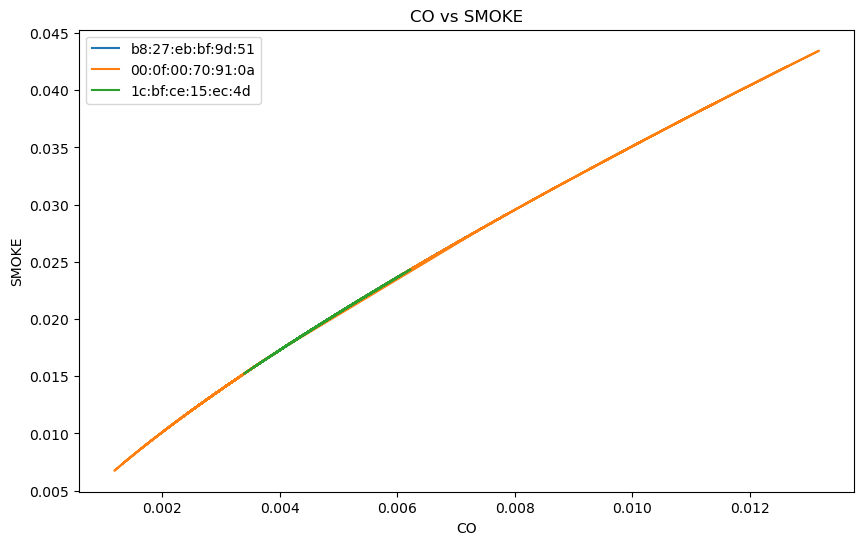

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique devices
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    ax.plot(device_data['co'], device_data['smoke'], label=device)

ax.set_xlabel('CO')
ax.set_ylabel('SMOKE')
ax.set_title('CO vs SMOKE')
ax.legend()
plt.show()

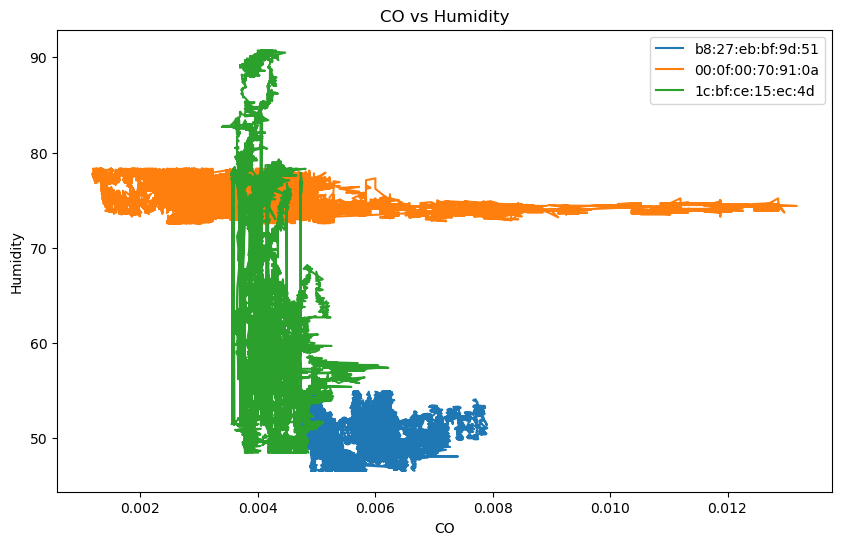

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique devices
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    ax.plot(device_data['co'], device_data['humidity'], label=device)

ax.set_xlabel('CO')
ax.set_ylabel('Humidity')
ax.set_title('CO vs Humidity')
ax.legend()
plt.show()

In [25]:
df['date'] = df['ts'].dt.date.astype(str)
df['time'] = df['ts'].dt.strftime("%H:%M:%S %Z")

In [26]:
df.drop('ts', axis=1, inplace=True)

In [27]:
df.head()

,device,co,humidity,light,lpg,motion,smoke,temp,date,time
0,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000,2020-07-12,00:01:34
1,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001,2020-07-12,00:01:34
2,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000,2020-07-12,00:01:38
3,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000,2020-07-12,00:01:39
4,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000,2020-07-12,00:01:41


In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co,385452.0,0.004629,0.001216,0.001181,0.003919,0.004797,0.005412,0.013180
humidity,385452.0,60.521401,11.206908,46.600000,51.100000,54.900000,74.400002,90.699997
lpg,385452.0,0.007228,0.001413,0.002711,0.006456,0.007472,0.008154,0.015524
smoke,385452.0,0.019237,0.003995,0.006738,0.017024,0.019902,0.021849,0.043461
temp,385452.0,72.442076,4.755615,65.660001,67.819999,71.960000,74.480001,86.360001


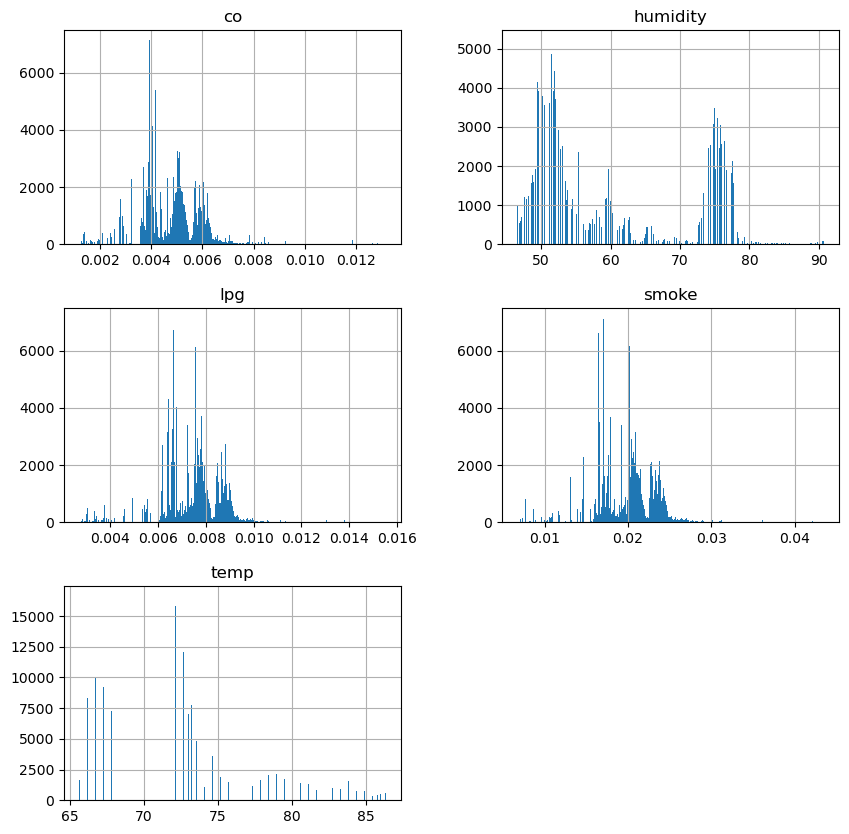

In [29]:
df.hist(bins=1000, figsize=(10, 10))
plt.show()

In [30]:
# Define the threshold
threshold = 0.005

# Create a new column 'label' based on CO levels
df['target'] = df['co'].apply(lambda x: 1 if x < threshold else 0)

df.head()

,device,co,humidity,light,lpg,motion,smoke,temp,date,time,target
0,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000,2020-07-12,00:01:34,1
1,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001,2020-07-12,00:01:34,1
2,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000,2020-07-12,00:01:38,1
3,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000,2020-07-12,00:01:39,1
4,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000,2020-07-12,00:01:41,1


In [31]:
df['target'].value_counts()

1    227607
0    157845
Name: target, dtype: int64

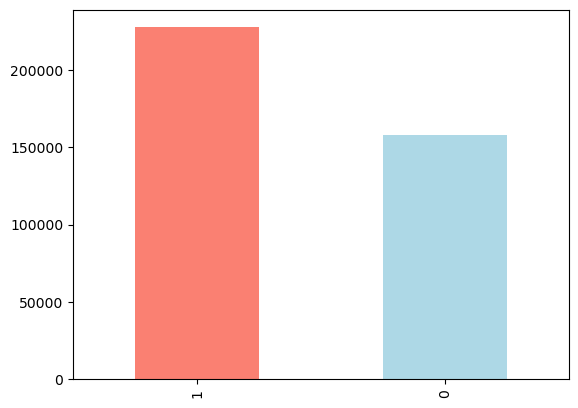

In [32]:
df.target.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [33]:
# Convert boolean values to integers
df['light'] = df['light'].astype(int)

In [34]:
# Convert boolean values to integers
df['motion'] = df['motion'].astype(int)

In [35]:
df['motion'].value_counts()

0    384997
1       455
Name: motion, dtype: int64

In [36]:
df['light'].value_counts()

0    278857
1    106595
Name: light, dtype: int64

In [37]:
df.head()

,device,co,humidity,light,lpg,motion,smoke,temp,date,time,target
0,b8:27:eb:bf:9d:51,0.004956,51.000000,0,0.007651,0,0.020411,72.860000,2020-07-12,00:01:34,1
1,00:0f:00:70:91:0a,0.002840,76.000000,0,0.005114,0,0.013275,67.460001,2020-07-12,00:01:34,1
2,b8:27:eb:bf:9d:51,0.004976,50.900000,0,0.007673,0,0.020475,72.680000,2020-07-12,00:01:38,1
3,1c:bf:ce:15:ec:4d,0.004403,76.800003,1,0.007023,0,0.018628,80.600000,2020-07-12,00:01:39,1
4,b8:27:eb:bf:9d:51,0.004967,50.900000,0,0.007664,0,0.020448,72.680000,2020-07-12,00:01:41,1


In [38]:
sample_size = 10000
rs = df.sample(n=sample_size, random_state=42)

In [39]:
# Split data into X and Y
x = rs.drop(["target","date","time","co"], axis=1)
y = rs["target"]

In [40]:
x.head()

,device,humidity,light,lpg,motion,smoke,temp
156474,b8:27:eb:bf:9d:51,46.600000,0,0.008127,0,0.021772,72.680000
76203,b8:27:eb:bf:9d:51,52.700000,0,0.007803,0,0.020845,71.060000
247425,1c:bf:ce:15:ec:4d,89.800003,1,0.006432,0,0.016957,75.560001
329862,b8:27:eb:bf:9d:51,52.600000,0,0.008435,0,0.022655,71.780000
121836,00:0f:00:70:91:0a,77.699997,0,0.006456,0,0.017024,68.000000


In [54]:
from category_encoders import OneHotEncoder

# Initialize and fit the OneHotEncoder
encoder = OneHotEncoder(cols=['device'])
x = encoder.fit_transform(x)

In [55]:
# Split data into train and test sets
np.random.seed(42)

# Split into train & test set
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2)



In [56]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),}

# Create a function to fit and score models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
    return model_scores

In [57]:
model_scores = fit_and_score(models=models,
                             x_train=x_train,
                             x_test=x_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores


{'Logistic Regression': 0.921, 'KNN': 0.9375}

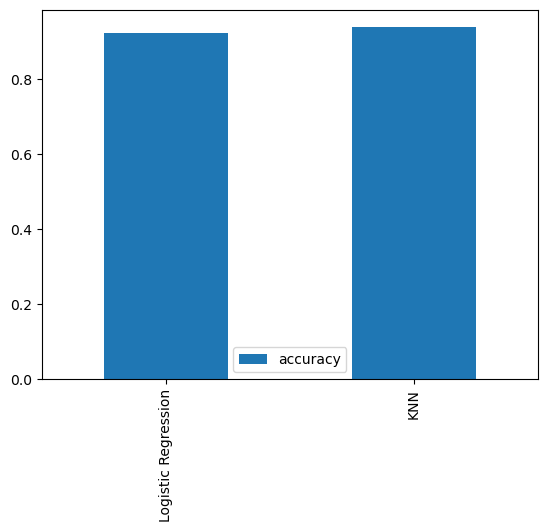

In [58]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

In [59]:
# Let's tune KNN

train_scores = []
test_scores = []

# Create a list of differnt values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(x_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(x_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(x_test, y_test))

In [60]:
train_scores

[1.0,
 0.973,
 0.967875,
 0.954,
 0.95,
 0.945,
 0.945625,
 0.942375,
 0.942125,
 0.9395,
 0.937875,
 0.93525,
 0.93425,
 0.93275,
 0.9335,
 0.93025,
 0.92925,
 0.928,
 0.927,
 0.928]

In [61]:
test_scores

[0.95,
 0.942,
 0.938,
 0.9355,
 0.9375,
 0.9365,
 0.9385,
 0.9375,
 0.9395,
 0.9395,
 0.942,
 0.943,
 0.942,
 0.9395,
 0.9385,
 0.9305,
 0.934,
 0.932,
 0.9325,
 0.934]

Maximum KNN score on the test data: 95.00%


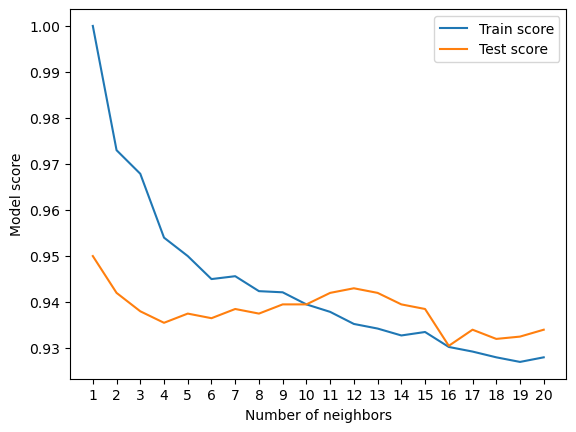

In [62]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

In [63]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

In [64]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [65]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 10000.0}

In [66]:
rs_log_reg.score(x_test, y_test)

0.9415

In [67]:
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(x_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [68]:
# Check the best hyperparmaters
gs_log_reg.best_params_

{'C': 5298.316906283702, 'solver': 'liblinear'}

In [69]:
# Evaluate the grid search LogisticRegression model
gs_log_reg.score(x_test, y_test)

0.935

In [73]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
#from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

def calculate_classification_metrics(models, x_test, y_test):
    metrics = {}
    
    for model_name, model in models.items():
        model.fit(x_train, y_train)  # Fit the model on the training data
        predictions = model.predict(x_test)
        
        classification_metrics = classification_report(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average='weighted')
        recall = recall_score(y_test, predictions, average='weighted')
        f_measure = f1_score(y_test, predictions, average='weighted')
        variance = np.var(predictions)
        std_deviation = np.std(predictions)
        mean = np.mean(predictions)
        mean_error = np.mean(np.abs(predictions - y_test))
        
        metrics[model_name] = {
            'Classification Metrics': classification_metrics,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F-measure': f_measure,
            'Variance': variance,
            'Standard Deviation': std_deviation,
            'Mean': mean,
            'Mean Error': mean_error
        }
    
    return metrics

# Dictionary of model names and models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=1),
    'LogisticRegression': LogisticRegression(),
    'ANN': MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000),
    'naive_bayes/GaussianNB': GaussianNB(),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'Support Vector Machine': SVC(),
    #'CatBoostClassifier' : CatBoostClassifier()
}

# Calculate classification metrics
classification_metrics = calculate_classification_metrics(models, x_test, y_test)

# Print the metrics for each model
for model_name, metrics in classification_metrics.items():
    print("Model:", model_name)
    print("Classification Metrics:")
    print(metrics['Classification Metrics'])
    print("Accuracy:", metrics['Accuracy'])
    print("Precision:", metrics['Precision'])
    print("Recall:", metrics['Recall'])
    print("F-measure:", metrics['F-measure'])
    print("Variance:", metrics['Variance'])
    print("Standard Deviation:", metrics['Standard Deviation'])
    print("Mean:", metrics['Mean'])
    print("Mean Error:", metrics['Mean Error'])
    print()

Model: KNN
Classification Metrics:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       811
           1       0.97      0.95      0.96      1189

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Accuracy: 0.95
Precision: 0.9503798488633872
Recall: 0.95
F-measure: 0.9500924625939733
Variance: 0.24285975000000007
Standard Deviation: 0.49280802550283215
Mean: 0.5845
Mean Error: 0.05

Model: LogisticRegression
Classification Metrics:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       811
           1       0.98      0.89      0.93      1189

    accuracy                           0.92      2000
   macro avg       0.92      0.93      0.92      2000
weighted avg       0.93      0.92      0.92      2000

Accuracy: 0.921
Precision: 0.9277788165943655
Recall: 0.921
F-measure: 0

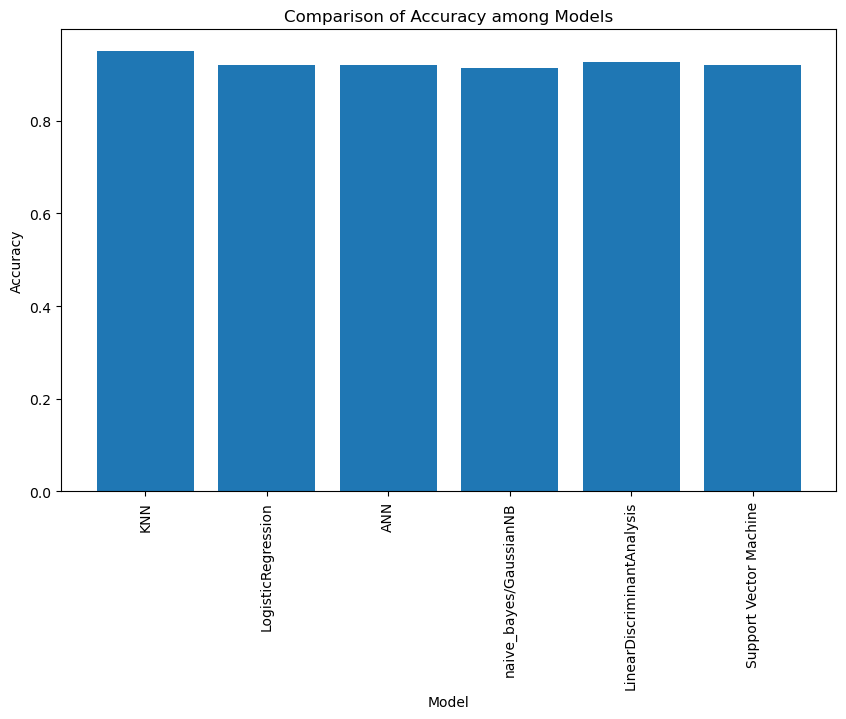

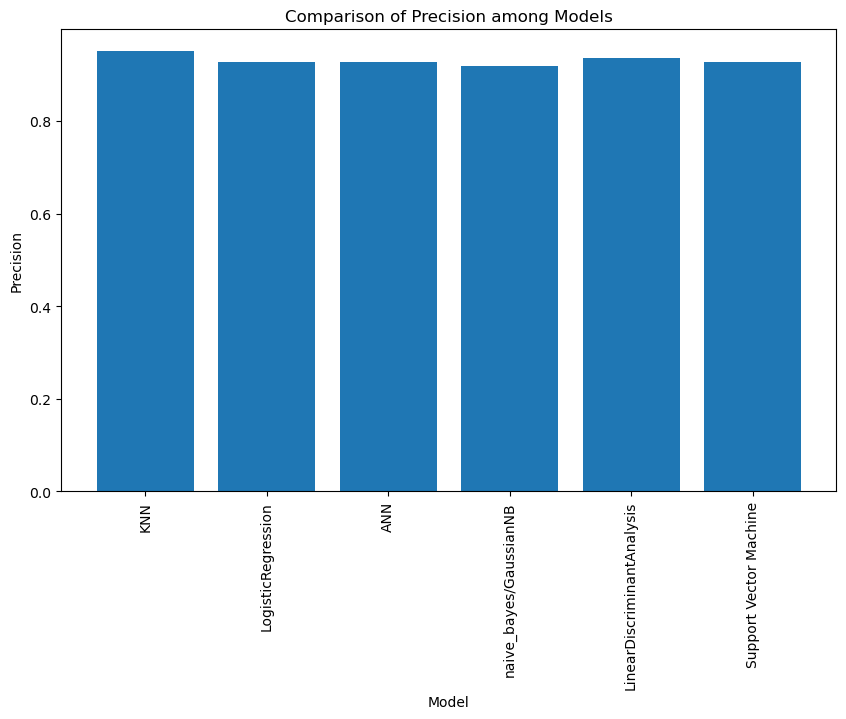

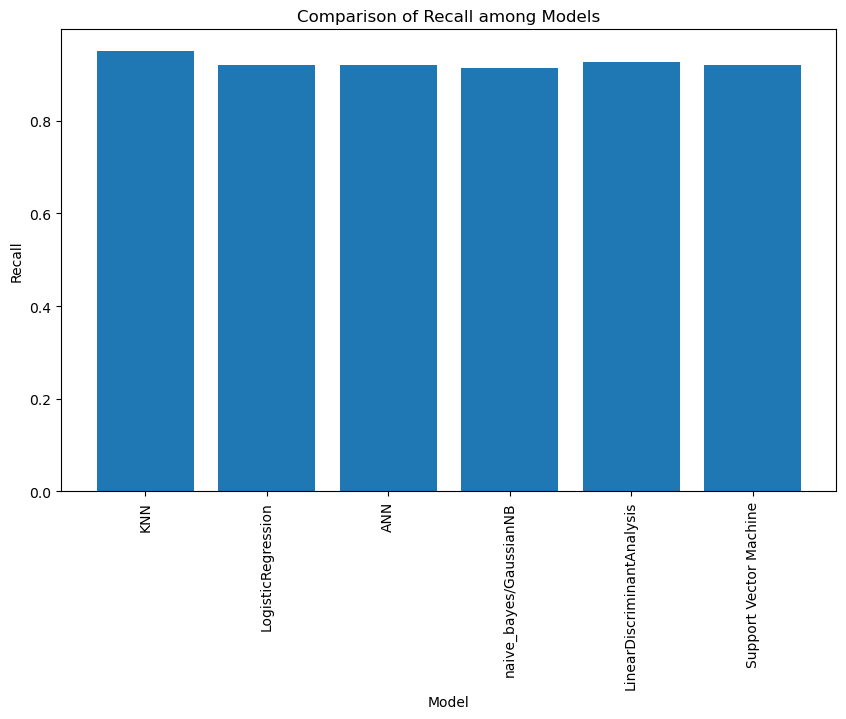

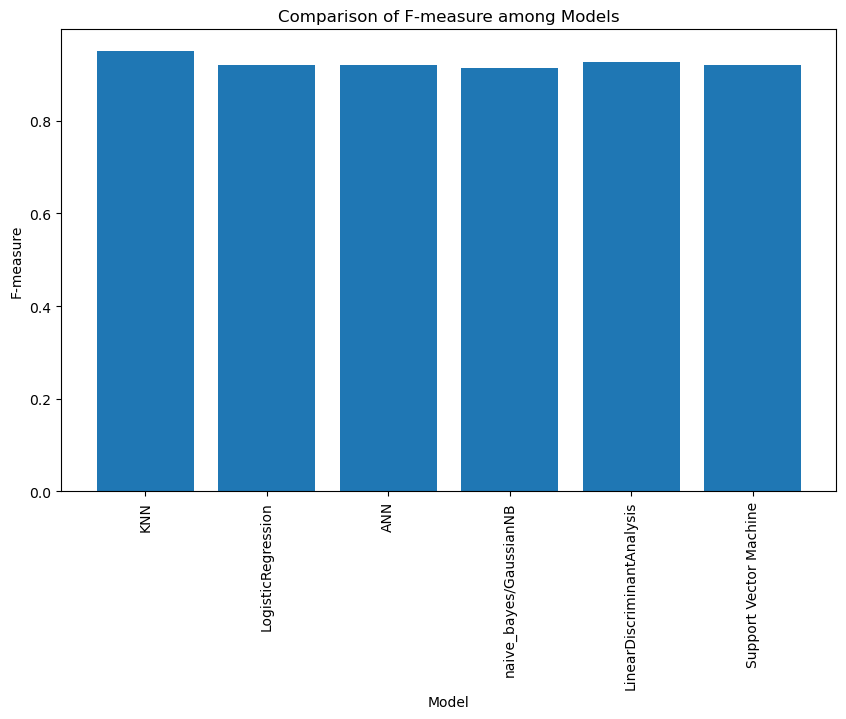

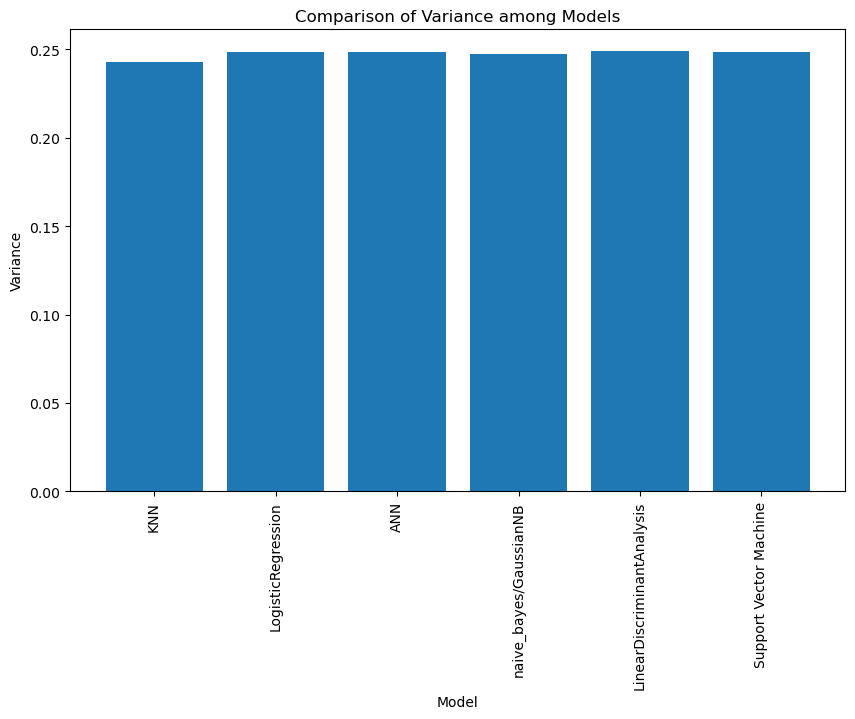

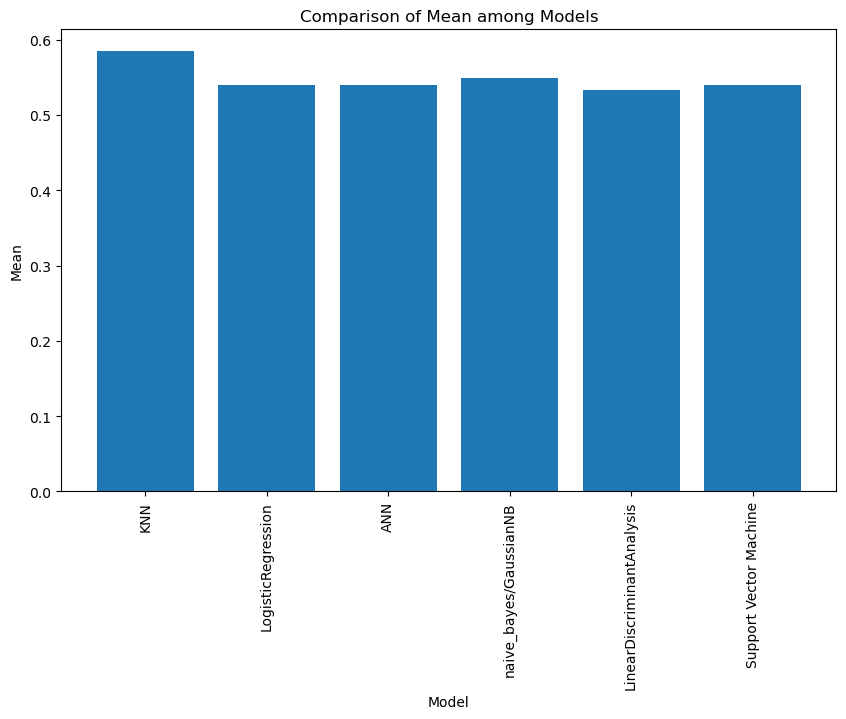

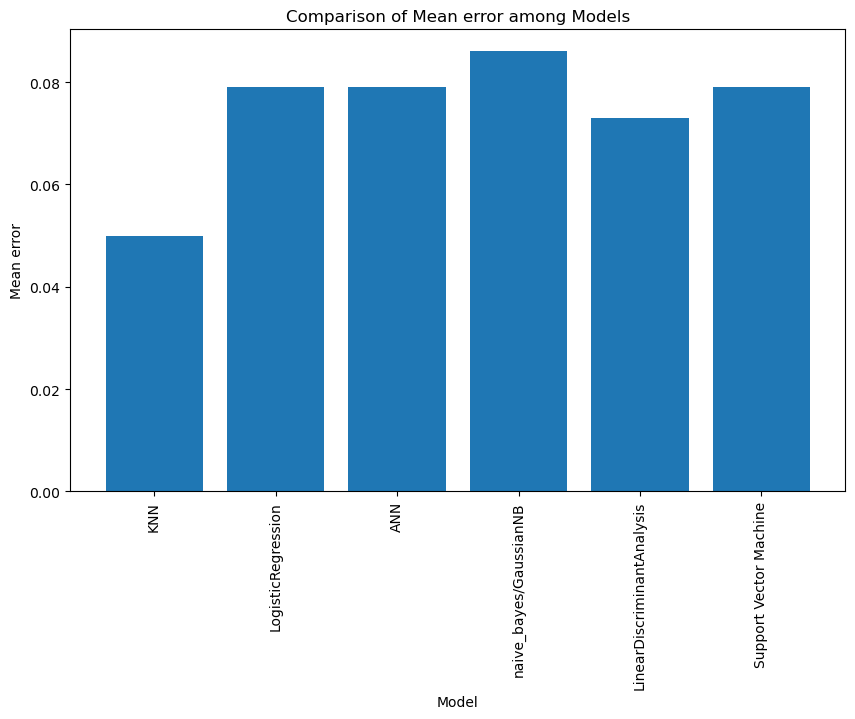

In [74]:
import matplotlib.pyplot as plt

# Initialize lists to store the metric values
model_names = []
accuracy_values = []
precision_values = []
Recall = []
F_measure = []
Variances = []
# Standard_Deviation = []
Mean = []
Mean_error = []

# Collect metric values for each model
for model_name, metrics in classification_metrics.items():
    model_names.append(model_name)
    accuracy_values.append(metrics['Accuracy'])
    precision_values.append(metrics['Precision'])
    Recall.append(metrics['Recall'])
    F_measure.append(metrics['F-measure'])
    Variances.append(metrics['Variance'])
    # Standard_Deviation(metrics['Standard Deviation'])
    Mean.append(metrics['Mean'])
    Mean_error.append(metrics['Mean Error'])
    

# Plot the comparison of accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy among Models')
plt.xticks(rotation=90)
plt.show()

# Plot the comparison of precision
plt.figure(figsize=(10, 6))
plt.bar(model_names, precision_values)
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Comparison of Precision among Models')
plt.xticks(rotation=90)
plt.show()

# Plot the comparison of recall
plt.figure(figsize=(10, 6))
plt.bar(model_names, Recall)
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Comparison of Recall among Models')
plt.xticks(rotation=90)
plt.show()

# Plot the comparison of F-measure
plt.figure(figsize=(10, 6))
plt.bar(model_names, F_measure)
plt.xlabel('Model')
plt.ylabel('F-measure')
plt.title('Comparison of F-measure among Models')
plt.xticks(rotation=90)
plt.show()

# Plot the comparison of variance   
plt.figure(figsize=(10, 6))
plt.bar(model_names, Variances)
plt.xlabel('Model')
plt.ylabel('Variance')
plt.title('Comparison of Variance among Models')
plt.xticks(rotation=90)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.bar(model_names, Standard_Deviation)
# plt.xlabel('Model')
# plt.ylabel('Standard Deviation')
# plt.title('Comparison of Standard Deviation among Models')
# plt.xticks(rotation=90)
# plt.show()

# Plot the comparison of variance   
plt.figure(figsize=(10, 6))
plt.bar(model_names, Mean)
plt.xlabel('Model')
plt.ylabel('Mean')
plt.title('Comparison of Mean among Models')
plt.xticks(rotation=90)
plt.show()


plt.figure(figsize=(10, 6))
plt.bar(model_names, Mean_error)
plt.xlabel('Model')
plt.ylabel('Mean error')
plt.title('Comparison of Mean error among Models')
plt.xticks(rotation=90)
plt.show()